# Data (from week 1) needed for our week 2 response
## Import

In [33]:
import xarray as xr
import pandas as pd
import rasterio
from rasterio.mask import mask
from rasterio.transform import from_bounds
import rioxarray
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import seaborn as sns
import scipy
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Concatenate, Embedding, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import statsmodels.api as sm
import scipy.stats as stats
from tqdm import tqdm
import os


## 1. Useful datas for final week

In [34]:
main_data_folder = "data/"
gadm_filepath = main_data_folder + "gadm_410_europe.gpkg"
country_code = "ESP" # Spain
cityname = "Madrid"

gadm_gdf = gpd.read_file(gadm_filepath)

print(f"Number of rows in GADM: {len(gadm_gdf)}")
filtered_gadm_gdf = gadm_gdf[(gadm_gdf.GID_0 == country_code) & (gadm_gdf.NAME_2 == cityname)]

print(f"Number of rows in GADM after filtering: {len(filtered_gadm_gdf)}")
filtered_gadm_gdf.head()

Number of rows in GADM: 106252
Number of rows in GADM after filtering: 181


,UID,GID_0,NAME_0,GID_1,NAME_1,ENGTYPE_1,GID_2,NAME_2,ENGTYPE_2,GID_3,...,ENGTYPE_3,GID_4,NAME_4,ENGTYPE_4,GID_5,NAME_5,ENGTYPE_5,COUNTRY,CONTINENT,geometry
90995,305016,ESP,Spain,ESP.8_1,Comunidad de Madrid,Autonomous Community,ESP.8.1_1,Madrid,Province,ESP.8.1.1_1,...,Comarca,ESP.8.1.1.1_1,Alameda del Valle,Municipality,,,,Spain,Europe,"MULTIPOLYGON (((-3.89887 40.95908, -3.89501 40..."
90996,305017,ESP,Spain,ESP.8_1,Comunidad de Madrid,Autonomous Community,ESP.8.1_1,Madrid,Province,ESP.8.1.1_1,...,Comarca,ESP.8.1.1.2_1,Berzosa del Lozoya,Municipality,,,,Spain,Europe,"MULTIPOLYGON (((-3.4963 40.99471, -3.49791 40...."
90997,305018,ESP,Spain,ESP.8_1,Comunidad de Madrid,Autonomous Community,ESP.8.1_1,Madrid,Province,ESP.8.1.1_1,...,Comarca,ESP.8.1.1.3_1,Braojos,Municipality,,,,Spain,Europe,"MULTIPOLYGON (((-3.70555 41.07751, -3.69502 41..."
90998,305019,ESP,Spain,ESP.8_1,Comunidad de Madrid,Autonomous Community,ESP.8.1_1,Madrid,Province,ESP.8.1.1_1,...,Comarca,ESP.8.1.1.4_1,Buitrago del Lozoya,Municipality,,,,Spain,Europe,"MULTIPOLYGON (((-3.6451 40.95414, -3.65023 40...."
90999,305020,ESP,Spain,ESP.8_1,Comunidad de Madrid,Autonomous Community,ESP.8.1_1,Madrid,Province,ESP.8.1.1_1,...,Comarca,ESP.8.1.1.5_1,Bustarviejo,Municipality,,,,Spain,Europe,"MULTIPOLYGON (((-3.79052 40.84676, -3.786 40.8..."


In [35]:
one_city_gdf = filtered_gadm_gdf.dissolve()

one_city_gdf.head()

,geometry,UID,GID_0,NAME_0,GID_1,NAME_1,ENGTYPE_1,GID_2,NAME_2,ENGTYPE_2,...,NAME_3,ENGTYPE_3,GID_4,NAME_4,ENGTYPE_4,GID_5,NAME_5,ENGTYPE_5,COUNTRY,CONTINENT
0,"MULTIPOLYGON (((-4.55042 40.20185, -4.57506 40...",305016,ESP,Spain,ESP.8_1,Comunidad de Madrid,Autonomous Community,ESP.8.1_1,Madrid,Province,...,n.a. (175),Comarca,ESP.8.1.1.1_1,Alameda del Valle,Municipality,,,,Spain,Europe


## ERA-5 Land


In [36]:
era5_data_folder = main_data_folder + "derived-era5-land-daily-statistics/"

variable2statistic = {
    "2m_temperature": "daily_maximum",
    "total_precipitation": "daily_mean",
    "10m_u_component_of_wind": "daily_mean",
    "10m_v_component_of_wind": "daily_mean",
}

variable2datavar = {
    "2m_temperature": "t2m",
    "total_precipitation": "tp",
    "10m_u_component_of_wind": "u10",
    "10m_v_component_of_wind": "v10",
}
origin_crs = "EPSG:4326"

variable = "2m_temperature"
year = 2020
statistic = variable2statistic[variable]
datavar = variable2datavar[variable]
filepath = f"{era5_data_folder}{year}_{variable}_{statistic}.nc"
ds = xr.open_dataset(filepath)
print(ds)
lat, lon = 39.8960, -2.4876
filepaths = glob(f"{era5_data_folder}*_{variable}_{statistic}.nc")
ds = xr.open_mfdataset(filepaths, combine="by_coords")


<xarray.Dataset> Size: 338MB
Dimensions:     (valid_time: 366, latitude: 350, longitude: 660)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 3kB 2020-01-01 ... 2020-12-31
  * latitude    (latitude) float64 3kB 69.9 69.8 69.7 69.6 ... 35.2 35.1 35.0
  * longitude   (longitude) float64 5kB -25.0 -24.9 -24.8 ... 40.7 40.8 40.9
    number      int64 8B ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 338MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-03T16:43 GRIB to CDM+CF via cfgrib-0.9.1...


## NDVI

In [37]:
ndvi_data_folder = main_data_folder + "sentinel2_ndvi/"

def quarter2timeperiod(year, quarter):
    if quarter == 1:
        return f"{year-1}-12-01_{year}-03-01"
    elif quarter == 2:
        return f"{year}-03-01_{year}-06-01"
    elif quarter == 3:
        return f"{year}-06-01_{year}-09-01"
    elif quarter == 4:
        return f"{year}-09-01_{year}-12-01"
    else:
        raise ValueError("quarter must be in 1, 2, 3, 4")


In [38]:
available_years = [2020, 2021, 2022, 2023]
available_quarters = [1, 2, 3, 4]
year = 2020
quarter = 3
timeperiod = quarter2timeperiod(year, quarter)

filepath  = f"{ndvi_data_folder}ndvi_{timeperiod}.tif"
day = pd.to_datetime(f"{year}-06-01")


In [39]:
def convert_ndvi_to_real_scale(ndvi_img, out_meta):
    # The NDVI is stored in int8 format on a 0/254 scale, and nodata is 255.
    # This function converts it to a float format on a -1/1 scale, and replace nodata with np.nan.
    ndvi_img = ndvi_img.astype(float)
    ndvi_img[ndvi_img == out_meta["nodata"]] = np.nan
    ndvi_img = ndvi_img / 254 * 2 - 1
    return ndvi_img

def get_out_image_and_metadata(filepath, one_city_gdf):
    with rasterio.open(filepath) as src:
        one_city_gdf_in_good_crs = one_city_gdf.to_crs(src.crs)
        city_geometry = [one_city_gdf_in_good_crs.geometry.iloc[0]]
        out_image, out_transform = mask(src, city_geometry, crop=True)
        out_meta = src.meta

        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })

        real_out_image = convert_ndvi_to_real_scale(out_image, out_meta)

    return real_out_image, out_meta

In [40]:
mean_ndvi_time_series = pd.Series(dtype=float)
for year in available_years:
    for quarter in available_quarters:
        timeperiod = quarter2timeperiod(year, quarter)
        filepath  = f"{ndvi_data_folder}ndvi_{timeperiod}.tif"
        date = pd.to_datetime(timeperiod.split("_")[1])
        current_real_out_image, _ = get_out_image_and_metadata(filepath, one_city_gdf)
        current_mean_ndvi = np.nanmean(current_real_out_image[0])
        mean_ndvi_time_series.loc[date] = current_mean_ndvi

mean_ndvi_time_series = mean_ndvi_time_series.sort_index()

## Stations



In [41]:
eca_tx_datafolder = main_data_folder + "ECA_blend_tx/"
stations_filepath = eca_tx_datafolder + "stations.txt"
def dms_to_decimal(dms_str):
    # This function converts a DMS (Degrees:Minutes:Seconds) string to decimal degrees.
    dms_str = dms_str.strip()
    
    sign = 1 if dms_str[0] == '+' else -1
    
    dms_str = dms_str[1:]
    
    parts = dms_str.split(':')
    degrees = float(parts[0])
    minutes = float(parts[1])
    seconds = float(parts[2])
    
    decimal = sign * (degrees + minutes/60 + seconds/3600)
    
    return decimal

In [42]:
stations_df = pd.read_csv(
    stations_filepath,
    skiprows=17,
    skipinitialspace=True
)

stations_df['LAT_decimal'] = stations_df['LAT'].apply(dms_to_decimal)
stations_df['LON_decimal'] = stations_df['LON'].apply(dms_to_decimal)

stations_gdf = gpd.GeoDataFrame(
    stations_df,
    geometry=gpd.points_from_xy(stations_df['LON_decimal'], stations_df['LAT_decimal']),
    crs="EPSG:4326" # (WGS84, adequate for lat/lon coordinates)
).drop(columns=['LAT', 'LON', 'LAT_decimal', 'LON_decimal'])

one_city_gdf.to_crs(stations_gdf.crs, inplace=True) # Use same CRS for spatial operations

stations_in_city_gdf = stations_gdf[stations_gdf.within(one_city_gdf.geometry.iloc[0])]
selected_station = stations_in_city_gdf.iloc[9]
selected_station_gdf = gpd.GeoDataFrame([selected_station], crs=stations_in_city_gdf.crs)
selected_station_STAID = selected_station['STAID']

station_data_filepath = eca_tx_datafolder + f"TX_STAID{selected_station_STAID:06d}.txt"

station_data_df = pd.read_csv(
    station_data_filepath,
    skiprows=20,
    skipinitialspace=True
)

valid_data_df = station_data_df[station_data_df['Q_TX'] == 0].copy() # Q_TX is the quality code for TX (0='valid')
valid_data_df['DATE'] = pd.to_datetime(valid_data_df['DATE'], format='%Y%m%d')
valid_data_df['TX_celsius'] = valid_data_df['TX'] / 10 # Convert temperature to °C (originally stored in 0.1°C unit)

tx_timeseries = pd.Series(
    valid_data_df['TX_celsius'].values,
    index=valid_data_df['DATE']
)

print(f"Number of valid daily records for station {selected_station_STAID}: {len(tx_timeseries)}")


Number of valid daily records for station 27223: 5992


## Useful functions

In [43]:
def quarter(month):
    if 1<=month<=3:
        return 1
    elif 4<=month<=6:
        return 2
    elif 7<=month<=9:
        return 3
    return 4

def get_season(month):
    if 1<=month<=3: return 'Spring' 
    elif 4<=month<=6: return 'Summer'
    elif 7<=month<=9: return 'Autumn'
    else: return 'Winter' 

In [44]:
"""Sorting the discrepancies by quarter"""
def transform_daily_into_quarter(discrepancies_daily):

    mean_discrepancies_by_quarter = pd.Series(dtype=float)
    valuesbyquarter = {}
    for date in discrepancies_daily.keys():
        year=date.year;month=date.month
        periodOfTime = quarter2timeperiod(year, quarter(month))
        new_date=pd.to_datetime(periodOfTime.split("_")[1])
        if new_date in mean_discrepancies_by_quarter.keys() and not np.isnan(discrepancies_daily[date]):
            valuesbyquarter[new_date].append(discrepancies_daily[date])
            mean_discrepancies_by_quarter[new_date]=np.mean(valuesbyquarter[new_date])
        elif new_date not in mean_discrepancies_by_quarter.keys() and not np.isnan(discrepancies_daily[date]):
            valuesbyquarter[new_date]=[discrepancies_daily[date]]
            mean_discrepancies_by_quarter[new_date]=discrepancies_daily[date]

    mean_discrepancies_by_quarter.sort_index()
    return mean_discrepancies_by_quarter

"""Restricting only to summer"""
def transform_daily_into_summer_only(discrepancies_daily):

    mean_discrepancies_by_quarter = pd.Series(dtype=float)
    valuesbyquarter = {}
    for date in discrepancies_daily.keys():
        year=date.year;month=date.month
        periodOfTime = quarter2timeperiod(year, quarter(month))
        new_date=pd.to_datetime(periodOfTime.split("_")[1])
        if quarter(month)==3:
            if new_date in mean_discrepancies_by_quarter.keys() and not np.isnan(discrepancies_daily[date]):
                valuesbyquarter[new_date].append(discrepancies_daily[date])
                mean_discrepancies_by_quarter[new_date]=np.mean(valuesbyquarter[new_date])
            elif new_date not in mean_discrepancies_by_quarter.keys() and not np.isnan(discrepancies_daily[date]):
                valuesbyquarter[new_date]=[discrepancies_daily[date]]
                mean_discrepancies_by_quarter[new_date]=discrepancies_daily[date]

    mean_discrepancies_by_quarter.sort_index()
    return mean_discrepancies_by_quarter

## Generating useful timed series

In [45]:
staids = stations_in_city_gdf["STAID"].unique()
num_stations = len(staids)
full_selected_stations={}
timed_series_stations={}
era5_timed_series_by_stations=pd.DataFrame({})
for staid in staids:
    point_i=stations_in_city_gdf.loc[stations_in_city_gdf['STAID'] == staid, 'geometry'].iloc[0]
    longitude_i = point_i.x
    latitude_i = point_i.y
    ds_sel_i = ds[datavar].sel(latitude=latitude_i, longitude=longitude_i, method="nearest")
    ds_sel_to_celsius_i = ds_sel_i - 273.15
    era5_timed_series_i=ds_sel_to_celsius_i.to_series()

    era5_timed_series_by_stations[staid]=era5_timed_series_i
station_cols = era5_timed_series_by_stations.columns
era5_timed_series_by_stations['Mean_stations'] = era5_timed_series_by_stations[station_cols].mean(axis=1)

era5_timed_series_by_stations.head()

,230,3839,3945,3946,3947,3948,27219,27221,27222,27223,...,27229,27230,27231,27232,27234,27238,27242,27244,27245,Mean_stations
valid_time,,,,,,,,,,,,,,,,,,,,,
2020-01-01,11.437592,11.612579,12.081329,11.648529,11.546967,11.162201,10.795013,10.929657,12.053986,11.582001,...,11.575470,11.117279,11.720795,11.546967,11.279388,12.231720,12.089935,12.307892,12.341095,11.649053
2020-01-02,9.301971,9.438141,9.705719,9.432281,9.346893,9.272675,9.163300,9.245514,10.140045,10.317780,...,9.426422,9.243378,9.451813,9.346893,9.462128,9.695953,9.891266,9.912750,9.713531,9.544270
2020-01-03,9.165497,8.638153,8.745575,9.136200,9.540497,8.974091,8.497528,7.035248,7.839935,7.162201,...,8.440887,8.401825,9.472137,9.540497,8.220184,8.716888,10.450653,10.343231,9.712372,8.883898
2020-01-04,10.441650,9.658447,8.115479,10.136963,10.467041,10.562744,10.263916,5.467041,6.215088,5.355713,...,9.402588,10.215088,10.265869,10.467041,9.734619,6.980713,9.750885,9.887604,8.863525,9.143907
2020-01-05,11.763184,11.747559,11.520996,11.940918,11.886230,11.429199,10.626465,9.441040,11.222290,10.302368,...,11.673340,11.228027,12.056152,11.886230,11.028809,10.917480,11.386230,11.720215,11.554199,11.395921


In [46]:
for i in range(num_stations):
    selected_station_i = stations_in_city_gdf.iloc[i]
    full_selected_stations[staids[i]] = gpd.GeoDataFrame([selected_station_i], crs=stations_in_city_gdf.crs)
    selected_station_STAID_i = selected_station_i['STAID']
    station_data_filepath_i = eca_tx_datafolder + f"TX_STAID{selected_station_STAID_i:06d}.txt"

    station_data_df_i = pd.read_csv(
        station_data_filepath_i,
        skiprows=20,
        skipinitialspace=True
    )

    valid_data_df_i = station_data_df_i[station_data_df_i['Q_TX'] == 0].copy() # Q_TX is the quality code for TX (0='valid')
    valid_data_df_i['DATE'] = pd.to_datetime(valid_data_df_i['DATE'], format='%Y%m%d')
    valid_data_df_i['TX_celsius'] = valid_data_df_i['TX'] / 10 # Convert temperature to °C (originally stored in 0.1°C unit)

    tx_timeseries_i = pd.Series(
        valid_data_df_i['TX_celsius'].values,
        index=valid_data_df_i['DATE']
    )
    timed_series_stations[staids[i]]=tx_timeseries_i



In [47]:
stations_df = pd.DataFrame({})
for staid in staids:
    stations_df[staid]=timed_series_stations[staid]
station_cols = stations_df.columns
stations_df['Mean_stations'] = stations_df[station_cols].mean(axis=1)
stations_df=stations_df.dropna()
stations_df.head()

,230,3839,3945,3946,3947,3948,27219,27221,27222,27223,...,27229,27230,27231,27232,27234,27238,27242,27244,27245,Mean_stations
DATE,,,,,,,,,,,,,,,,,,,,,
2012-02-19,13.4,14.6,11.7,15.0,14.4,14.8,15.0,10.7,10.0,5.5,...,15.1,15.7,15.0,15.0,14.3,15.3,12.0,13.7,13.6,13.400000
2012-02-22,14.6,16.2,13.0,16.3,15.5,16.2,16.1,14.1,13.7,9.0,...,16.5,17.3,16.8,16.6,15.6,15.6,13.5,15.2,14.3,14.995238
2012-02-26,20.4,21.3,18.8,22.0,21.0,21.5,22.4,17.8,16.7,11.7,...,22.3,22.7,22.0,22.2,21.5,18.9,18.2,19.8,20.6,20.138095
2012-02-27,18.8,19.0,16.9,20.2,20.0,20.2,20.9,17.8,17.5,14.7,...,20.5,20.4,19.8,20.6,20.1,20.9,17.5,19.1,19.5,19.066667
2012-02-28,18.6,19.7,17.0,20.9,19.5,20.2,21.5,17.3,16.2,15.5,...,20.8,21.7,20.2,20.4,20.9,19.7,17.5,19.5,19.0,19.204762


In [48]:
discreptancies_by_stations = pd.DataFrame({})
for staid in staids:
    discreptancies_by_stations[staid]=(stations_df[staid]-era5_timed_series_by_stations[staid]).dropna()
discreptancies_by_stations['Mean_stations']=stations_df['Mean_stations']-era5_timed_series_by_stations['Mean_stations']
discreptancies_by_stations.head()

,230,3839,3945,3946,3947,3948,27219,27221,27222,27223,...,27229,27230,27231,27232,27234,27238,27242,27244,27245,Mean_stations
2020-01-01,-0.237592,1.687421,0.218671,1.151471,1.953033,1.637799,1.704987,7.070343,3.246014,1.417999,...,2.024530,2.182721,1.979205,3.853033,1.320612,5.268280,1.910065,1.192108,1.558905,2.065233
2020-01-02,1.198029,2.761859,0.694281,3.467719,2.653107,3.127325,4.236700,6.454486,2.359955,4.082220,...,3.473578,3.056622,2.648187,3.753107,2.437872,4.704047,2.708734,1.887250,2.286469,2.993826
2020-01-03,-3.165497,-4.038153,-1.445575,-4.636200,-2.840497,-3.174091,-1.697528,4.764752,2.660065,-4.062201,...,-2.540887,-2.901825,-2.872137,-1.840497,-2.220184,0.783112,-3.050653,-2.643231,-2.212372,-2.145803
2020-01-04,0.758350,2.241553,1.584521,2.263037,1.432959,1.437256,2.836084,7.632959,5.084912,-1.255713,...,3.197412,2.684912,1.534131,2.132959,2.665381,3.919287,0.649115,0.712396,2.036475,2.217998
2020-01-05,-0.863184,-0.047559,1.479004,1.059082,1.613770,0.970801,1.073535,8.158960,5.977710,4.097632,...,1.026660,0.571973,1.243848,3.613770,0.771191,7.382520,1.313770,2.279785,2.745801,2.251698


## Calculate NDVI for each station area + the city

In [49]:
ndvi_stations_dict = {staid: [] for staid in stations_in_city_gdf['STAID']}
ndvi_dates = []

for year in available_years:
    for q in available_quarters:
        timeperiod = quarter2timeperiod(year, q)
        filepath = f"{ndvi_data_folder}ndvi_{timeperiod}.tif"
        
        current_date = pd.to_datetime(timeperiod.split("_")[1])
        ndvi_dates.append(current_date)
        
        with rasterio.open(filepath) as src:
            stations_projected = stations_in_city_gdf.to_crs(src.crs)
            
            coords = [(geom.x, geom.y) for geom in stations_projected.geometry]
            
            sampled_values = src.sample(coords)
            
            for staid, val in zip(stations_in_city_gdf['STAID'], sampled_values):
                raw_val = val[0] 
                
                if raw_val == src.nodata:
                    real_ndvi = np.nan
                else:
                    real_ndvi = (float(raw_val) / 254.0 * 2.0) - 1.0
                
                ndvi_stations_dict[staid].append(real_ndvi)
ndvi_stations_dict['Mean_stations']=mean_ndvi_time_series
ndvi_stations_df = pd.DataFrame(ndvi_stations_dict, index=ndvi_dates)
ndvi_stations_df = ndvi_stations_df.sort_index()

ndvi_stations_df.head()

,230,3839,3945,3946,3947,3948,27219,27221,27222,27223,...,27229,27230,27231,27232,27234,27238,27242,27244,27245,Mean_stations
2020-03-01,0.590551,0.818898,0.125984,0.700787,0.181102,0.401575,0.448819,0.566929,0.535433,0.551181,...,0.496063,0.251969,0.645669,0.212598,0.251969,0.023622,0.629921,0.338583,0.409449,0.485405
2020-06-01,0.503937,0.716535,0.118110,0.535433,0.149606,0.283465,0.440945,0.614173,0.622047,0.629921,...,0.346457,0.267717,0.551181,0.204724,0.212598,0.031496,0.661417,0.299213,0.519685,0.477942
2020-09-01,0.582677,0.220472,0.070866,0.181102,0.078740,0.118110,0.370079,0.370079,0.370079,0.566929,...,0.228346,0.228346,0.314961,0.228346,0.173228,0.023622,0.551181,0.133858,0.251969,0.328603
2020-12-01,0.590551,0.472441,0.102362,0.543307,0.110236,0.157480,0.409449,0.598425,0.456693,0.590551,...,0.283465,0.314961,0.511811,0.228346,0.212598,0.023622,0.606299,0.251969,0.433071,0.393353
2021-03-01,0.480315,0.637795,0.118110,0.653543,0.149606,0.196850,0.338583,0.299213,0.448819,0.346457,...,0.283465,0.133858,0.535433,0.173228,0.204724,0.039370,0.377953,0.212598,0.433071,0.368942


## 2. Our answer for this last week



Objective : *summarize our findings and propose explanatory models or adjustments to existing data.*

In [50]:
spain_full_gdf = gadm_gdf[(gadm_gdf.GID_0 == "ESP")].dissolve()

stations_in_spain_full = stations_gdf[stations_gdf.within(spain_full_gdf.geometry.iloc[0])]
print(f"-> {len(stations_in_spain_full)} stations trouvées en Espagne (Total).")

madrid_city_gdf = gadm_gdf[(gadm_gdf.GID_0 == "ESP") & (gadm_gdf.NAME_2 == "Madrid")].dissolve()
madrid_staids = stations_gdf[stations_gdf.within(madrid_city_gdf.geometry.iloc[0])]['STAID'].unique()
print(f"-> {len(madrid_staids)} stations à Madrid (Test Set).")


all_data_list = []
available_years = [2020, 2021, 2022, 2023]

ndvi_stations_dict_full = {}
for staid in stations_in_spain_full['STAID'].unique():
    if staid in ndvi_stations_df.columns:
        ndvi_stations_dict_full[staid] = ndvi_stations_df[staid]
    
datavar = 't2m'

for idx, station in tqdm(stations_in_spain_full.iterrows(), total=len(stations_in_spain_full), desc="Assemblage du DataFrame final"):
    try:
        staid = station['STAID']
        fpath = eca_tx_datafolder + f"TX_STAID{staid:06d}.txt"
        if not os.path.exists(fpath): continue
            
        df_s = pd.read_csv(fpath, skiprows=20, skipinitialspace=True)
        df_s = df_s[df_s['Q_TX'] == 0]
        df_s['DATE'] = pd.to_datetime(df_s['DATE'], format='%Y%m%d')
        df_s = df_s.set_index('DATE').sort_index()
        
        start_date = pd.Timestamp(min(available_years), 1, 1)
        end_date = pd.Timestamp(max(available_years), 12, 31)
        df_s = df_s.loc[(df_s.index >= start_date) & (df_s.index <= end_date)]
        
        if len(df_s) < 100: continue
            
        station_series = df_s['TX'] / 10.0
        station_series.name = 'Station_TX'

        lat_s, lon_s = station.geometry.y, station.geometry.x
        era5_point = ds[datavar].sel(latitude=lat_s, longitude=lon_s, method="nearest")
        era5_series = era5_point.to_series() - 273.15
        era5_series.name = 'ERA5_TX'

        ndvi_series_raw = pd.Series(ndvi_stations_dict_full.get(staid, {}))
        if ndvi_series_raw.empty:
            ndvi_series_raw = mean_ndvi_time_series.rename('NDVI')
        
        ndvi_series = ndvi_series_raw.reindex(station_series.index, method='ffill')
        ndvi_series.name = 'NDVI'

        merged = pd.concat([station_series, era5_series, ndvi_series], axis=1).dropna()
        if len(merged) == 0: continue
            
        df_temp = pd.DataFrame({
            'Date': merged.index,
            'Station_ID': staid,
            'Station_TX': merged['Station_TX'].values,
            'ERA5_TX': merged['ERA5_TX'].values,
            'NDVI': merged['NDVI'].values,
            'Month_Num': merged.index.month
        })
        
        all_data_list.append(df_temp)
        
    except Exception as e:
        continue

df_full_spain = pd.concat(all_data_list, ignore_index=False)
df_full_spain['Month_Sin'] = np.sin(2 * np.pi * df_full_spain['Month_Num']/12)
df_full_spain['Month_Cos'] = np.cos(2 * np.pi * df_full_spain['Month_Num']/12)
df_full_spain = df_full_spain.set_index('Date').drop(columns=['Month_Num']).dropna().copy()


df_train = df_full_spain[~df_full_spain['Station_ID'].isin(madrid_staids)].copy()
df_test = df_full_spain[df_full_spain['Station_ID'].isin(madrid_staids)].copy()

print(f"\nTAILLE TRAIN SET (Espagne - Madrid) : {len(df_train)} points")
print(f"TAILLE TEST SET (Madrid) : {len(df_test)} points")


features = ['ERA5_TX', 'NDVI', 'Month_Sin', 'Month_Cos']
target = 'Station_TX'

-> 921 stations trouvées en Espagne (Total).
-> 21 stations à Madrid (Test Set).


Assemblage du DataFrame final: 100%|██████████| 921/921 [03:24<00:00,  4.50it/s]



TAILLE TRAIN SET (Espagne - Madrid) : 1096195 points
TAILLE TEST SET (Madrid) : 28273 points


## First method : multivariate linear regression

In [51]:
df_train_lr = df_full_spain[~df_full_spain['Station_ID'].isin(madrid_staids)].copy()
df_test_lr = df_full_spain[df_full_spain['Station_ID'].isin(madrid_staids)].copy()

print(f"TRAIN SET length (Spain except Madrid) : {len(df_train_lr)} points")
print(f"TEST SET length (Madrid) : {len(df_test_lr)} points")

features = ['ERA5_TX', 'NDVI', 'Month_Sin', 'Month_Cos']
target = 'Station_TX'

if len(df_train_lr) > 0 and len(df_test_lr) > 0:
    lr_model = LinearRegression()
    lr_model.fit(df_train_lr[features], df_train_lr[target])
    print("\nTraining successfull outside Madrid.")

    y_pred_madrid_lr = lr_model.predict(df_test_lr[features])
    y_test_madrid_lr = df_test_lr[target].values
    y_era5_madrid_lr = df_test_lr['ERA5_TX'].values

    rmse_era5 = np.sqrt(mean_squared_error(y_test_madrid_lr, y_era5_madrid_lr))
    rmse_model = np.sqrt(mean_squared_error(y_test_madrid_lr, y_pred_madrid_lr))
    mae_era5 = mean_absolute_error(y_test_madrid_lr, y_era5_madrid_lr)
    mae_model = mean_absolute_error(y_test_madrid_lr, y_pred_madrid_lr)
    bias = np.mean(y_test_madrid_lr- y_pred_madrid_lr)

    print("\n# ==========================================================================")
    print("# Linear Regression results on Madrid")
    print("# ==========================================================================")
    print(f"RMSE ERA5 (Original): {rmse_era5:.4f} °C")
    print(f"RMSE Model (Corrected) on Madrid: {rmse_model:.4f} °C")
    print(f"RMSE Gain : {rmse_era5 - rmse_model:.4f} °C")
    print(f"MAE ERA5 (Original) on Madrid: {mae_era5:.4f} °C")
    print(f"MAE Model (Corrected) on Madrid: {mae_model:.4f} °C")
    print(f"Bias of the Model (Corrected) on Madrid: {bias:.4f} °C")
    
    df_results_madrid_lr = pd.DataFrame({
        'Reality (Station)': df_test_lr.groupby('Date')[target].mean(),
        'Original ERA5 (Before)': df_test_lr.groupby('Date')['ERA5_TX'].mean(),
        'Corrected ERA5 (LR Model)': pd.Series(y_pred_madrid_lr, index=df_test_lr.index).groupby('Date').mean()
    }).dropna()

    num_days = 365
    df_plot_subset = df_results_madrid_lr.head(num_days)
    
else:
    print("\nError on extracting data.")

TRAIN SET length (Spain except Madrid) : 1096195 points
TEST SET length (Madrid) : 28273 points

Training successfull outside Madrid.

# ==========================================================================
# Linear Regression results on Madrid
# ==========================================================================
RMSE ERA5 (Original): 2.2550 °C
RMSE Model (Corrected) on Madrid: 1.7955 °C
RMSE Gain : 0.4596 °C
MAE ERA5 (Original) on Madrid: 1.7697 °C
MAE Model (Corrected) on Madrid: 1.3900 °C
Bias of the Model (Corrected) on Madrid: -0.2675 °C


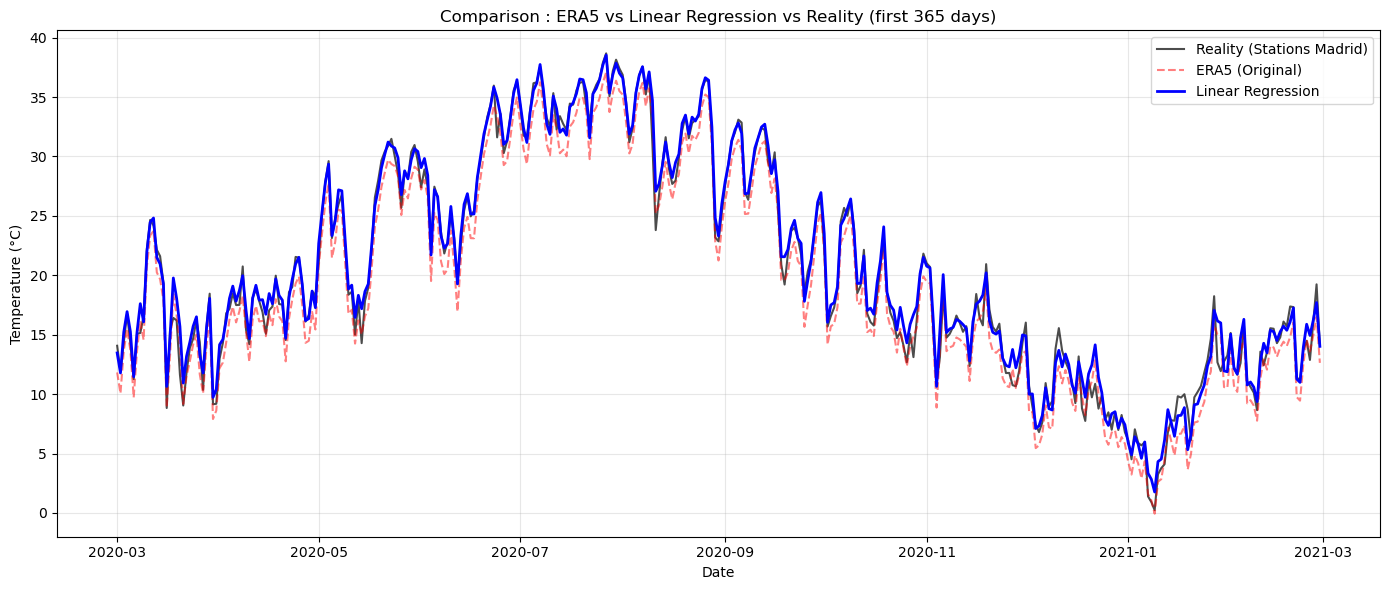

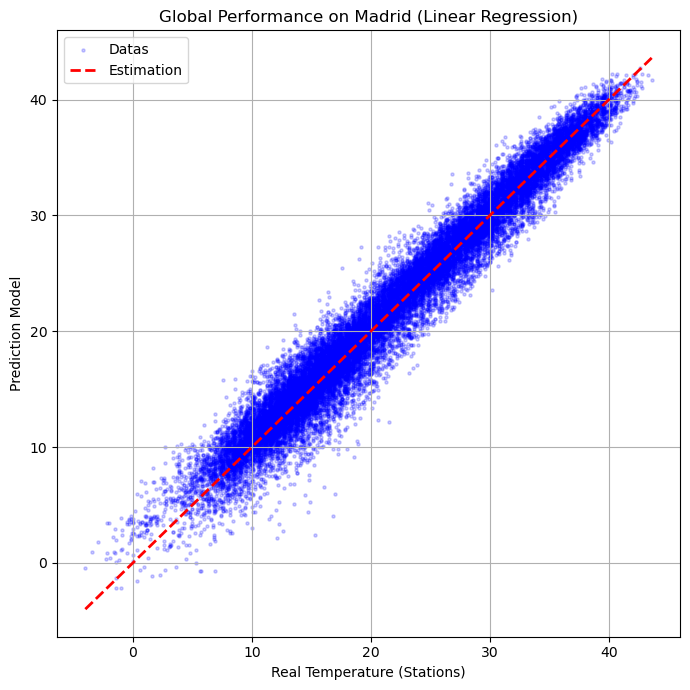

In [52]:
# Plot 1:
plt.figure(figsize=(14, 6))
plt.plot(df_plot_subset.index, df_plot_subset['Reality (Station)'], 
            label='Reality (Stations Madrid)', color='black', alpha=0.7)
plt.plot(df_plot_subset.index, df_plot_subset['Original ERA5 (Before)'], 
            label='ERA5 (Original)', color='red', linestyle='--', alpha=0.5)
plt.plot(df_plot_subset.index, df_plot_subset['Corrected ERA5 (LR Model)'], 
            label='Linear Regression', color='blue', linewidth=2)

plt.title(f'Comparison : ERA5 vs Linear Regression vs Reality (first {len(df_plot_subset)} days)')
plt.ylabel('Temperature (°C)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Plot 2: 
plt.figure(figsize=(7, 7))
plt.scatter(y_test_madrid_lr, y_pred_madrid_lr, alpha=0.2, s=5, c='blue', label='Datas')
plt.plot([y_test_madrid_lr.min(), y_test_madrid_lr.max()], 
            [y_test_madrid_lr.min(), y_test_madrid_lr.max()], 'r--', linewidth=2, label='Estimation')
plt.xlabel("Real Temperature (Stations)")
plt.ylabel("Prediction Model")
plt.title("Global Performance on Madrid (Linear Regression)")
plt.legend()
plt.grid(True)
plt.tight_layout()

## Second method : using RandomForest

In [53]:
all_data_list = []
stations_list = [c for c in stations_df.columns if 'Mean' not in str(c)]

for staid in stations_list:
    if staid not in ndvi_stations_df.columns: continue
    
    temp_station = stations_df['Mean_stations']
    era5_for_station = era5_timed_series_by_stations[staid]
    ndvi_for_station = ndvi_stations_df[staid]
    ndvi_daily = ndvi_for_station.reindex(temp_station.index, method='ffill')

    df_temp = pd.DataFrame({
        'Date': temp_station.index,
        'Station_ID': staid,
        'Station_TX': temp_station.values,
        'ERA5_TX': era5_for_station.reindex(temp_station.index).values,
        'NDVI': ndvi_daily.values
    })
    all_data_list.append(df_temp)

df_final = pd.concat(all_data_list, ignore_index=False)
df_final['Month'] = df_final['Date'].dt.month


df_final['Season'] = df_final['Month'].apply(get_season)
df_final['Error'] = df_final['Station_TX']-df_final['ERA5_TX']
df_sim = df_final.dropna()
df_simulation = df_sim.set_index('Date')

In [54]:
df_final['Month_Num'] = df_final['Date'].dt.month

df_final['Month_Sin'] = np.sin(2 * np.pi * df_final['Month_Num']/12)
df_final['Month_Cos'] = np.cos(2 * np.pi * df_final['Month_Num']/12)

def get_season(month):
    if month in [1, 2,3]: return 'Winter'
    elif month in [4, 5, 6]: return 'Spring'
    elif month in [7, 8, 9]: return 'Summer'
    else: return 'Autumn'

df_final['Season'] = df_final['Month_Num'].apply(get_season)

df_model = df_final.dropna().copy()

features = ['ERA5_TX', 'NDVI', 'Month_Sin', 'Month_Cos']
target = 'Station_TX'

rf_global = RandomForestRegressor(n_estimators=100, max_depth=12, n_jobs=-1, random_state=42)
rf_global.fit(df_model[features], df_model[target])

df_model['Corrected_TX'] = rf_global.predict(df_model[features])

# Calcul des erreurs
df_model['Error_ERA5'] = df_model['Station_TX'] - df_model['ERA5_TX']
df_model['Error_Corrected'] = df_model['Station_TX'] - df_model['Corrected_TX']



In [55]:
if len(df_train) > 0 and len(df_test) > 0:
    # Training sur Espagne except Madrid
    rf_new = RandomForestRegressor(n_estimators=100, max_depth=12, n_jobs=-1, random_state=42)
    rf_new.fit(df_train[features], df_train[target])
    print("\nTraining finished.")

    y_pred_madrid = rf_new.predict(df_test[features])
    y_test_madrid = df_test[target].values
    y_era5_madrid = df_test['ERA5_TX'].values

    rmse_era5 = np.sqrt(mean_squared_error(y_test_madrid, y_era5_madrid))
    rmse_model = np.sqrt(mean_squared_error(y_test_madrid, y_pred_madrid))
    mae_era5 = mean_absolute_error(y_test_madrid, y_era5_madrid)
    mae_model = mean_absolute_error(y_test_madrid, y_pred_madrid)

    print("\n# ==========================================================================")
    print("# Random Forest results on Madrid (trained on Spain outside of Madrid)")
    print("# ==========================================================================")
    print(f"RMSE ERA5 (Original): {rmse_era5:.4f} °C")
    print(f"RMSE RF (Corrected) on Madrid: {rmse_model:.4f} °C")
    print(f"RMSE Gain : {rmse_era5 - rmse_model:.4f} °C")
    print(f"MAE ERA5 (Original) on Madrid: {mae_era5:.4f} °C")
    print(f"MAE RF (Corrected) on Madrid: {mae_model:.4f} °C")

    df_results_madrid = pd.DataFrame({
        'Reality (Station)': df_test.groupby('Date')[target].mean(),
        'Original ERA5 (Before)': df_test.groupby('Date')['ERA5_TX'].mean(),
        'Corrected ERA5 (RF Model)': pd.Series(y_pred_madrid, index=df_test.index).groupby('Date').mean()
    }).dropna()

    num_days = 365
    df_plot_subset = df_results_madrid.head(num_days)
    
else:
    print("\n Error on extracting data.")


Training finished.

# ==========================================================================
# Random Forest results on Madrid (trained on Spain outside of Madrid)
# ==========================================================================
RMSE ERA5 (Original): 2.2550 °C
RMSE RF (Corrected) on Madrid: 1.8119 °C
RMSE Gain : 0.4431 °C
MAE ERA5 (Original) on Madrid: 1.7697 °C
MAE RF (Corrected) on Madrid: 1.3989 °C


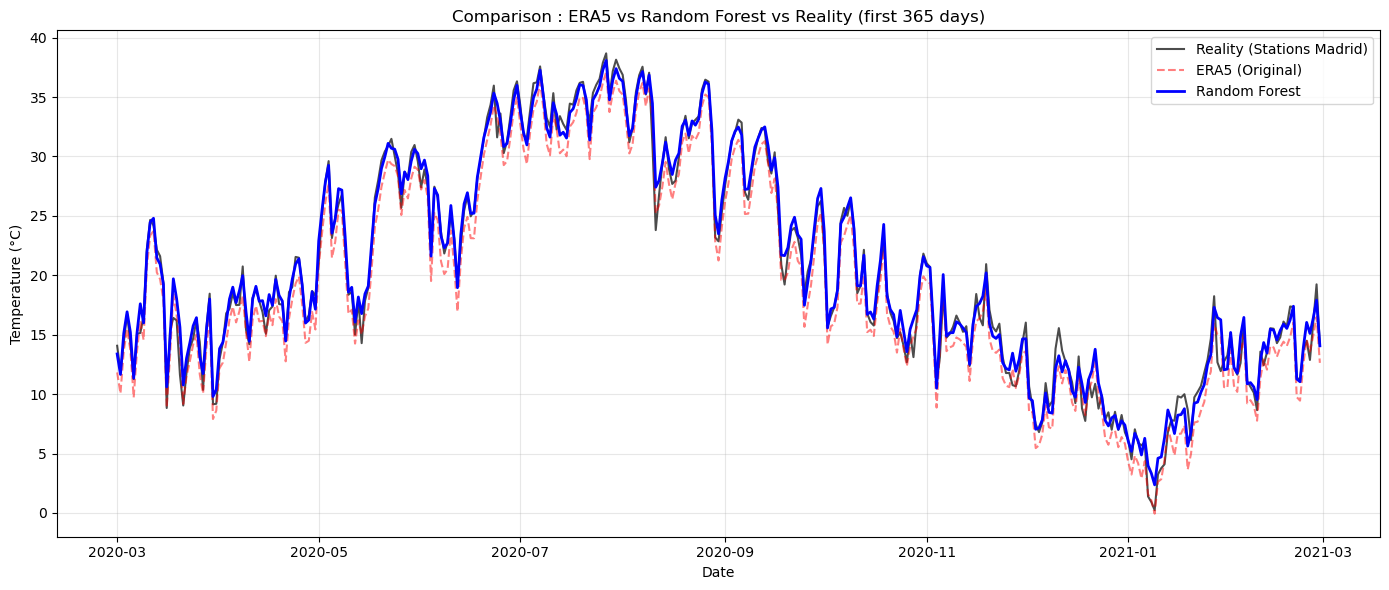

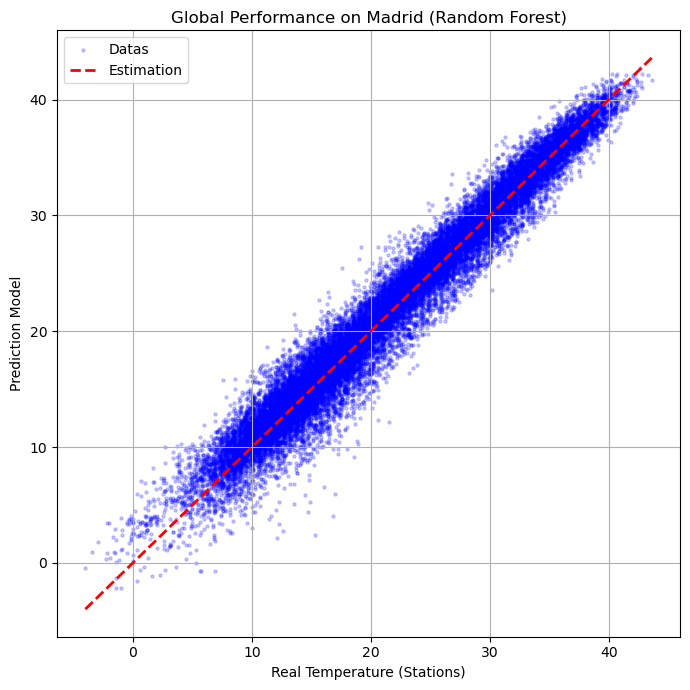

In [56]:
# Plot 1:
plt.figure(figsize=(14, 6))
plt.plot(df_plot_subset.index, df_plot_subset['Reality (Station)'], 
            label='Reality (Stations Madrid)', color='black', alpha=0.7)
plt.plot(df_plot_subset.index, df_plot_subset['Original ERA5 (Before)'], 
            label='ERA5 (Original)', color='red', linestyle='--', alpha=0.5)
plt.plot(df_plot_subset.index, df_plot_subset['Corrected ERA5 (RF Model)'], 
            label='Random Forest', color='blue', linewidth=2)

plt.title(f'Comparison : ERA5 vs Random Forest vs Reality (first {len(df_plot_subset)} days)')
plt.ylabel('Temperature (°C)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Plot 2: 
plt.figure(figsize=(7, 7))
plt.scatter(y_test_madrid_lr, y_pred_madrid_lr, alpha=0.2, s=5, c='blue', label='Datas')
plt.plot([y_test_madrid_lr.min(), y_test_madrid_lr.max()], 
            [y_test_madrid_lr.min(), y_test_madrid_lr.max()], 'r--', linewidth=2, label='Estimation')
plt.xlabel("Real Temperature (Stations)")
plt.ylabel("Prediction Model")
plt.title("Global Performance on Madrid (Random Forest)")
plt.legend()
plt.grid(True)
plt.tight_layout()

In [57]:
df_final['Month_Num'] = df_final['Date'].dt.month

df_final['Month_Sin'] = np.sin(2 * np.pi * df_final['Month_Num']/12)
df_final['Month_Cos'] = np.cos(2 * np.pi * df_final['Month_Num']/12)

df_final['Season'] = df_final['Month_Num'].apply(get_season)

df_model = df_final.dropna().copy()

features = ['ERA5_TX', 'NDVI', 'Month_Sin', 'Month_Cos']
target = 'Station_TX'

rf_global = RandomForestRegressor(n_estimators=100, max_depth=12, n_jobs=-1, random_state=42)
rf_global.fit(df_model[features], df_model[target])

df_model['Corrected_TX'] = rf_global.predict(df_model[features])

df_model['Error_ERA5'] = df_model['Station_TX'] - df_model['ERA5_TX']
df_model['Error_Corrected'] = df_model['Station_TX'] - df_model['Corrected_TX']



In [58]:
seasonal_stats = df_model.groupby('Season').apply(
    lambda x: pd.Series({
        'RMSE_ERA5': np.sqrt(mean_squared_error(x['Station_TX'], x['ERA5_TX'])),
        'RMSE_Corrected': np.sqrt(mean_squared_error(x['Station_TX'], x['Corrected_TX'])),
        'Count': len(x)
    })
).reset_index()

seasonal_stats['Gain'] = seasonal_stats['RMSE_ERA5'] - seasonal_stats['RMSE_Corrected']


plt.figure(figsize=(12, 6))

season_order = ['Winter', 'Spring', 'Summer', 'Autumn']
df_model['Season'] = pd.Categorical(df_model['Season'], categories=season_order, ordered=True)
print(df_model.head())


          Date  Station_ID  Station_TX    ERA5_TX      NDVI  Month  Season  \
506 2020-03-01         230   14.071429  12.287079  0.590551      3  Winter   
507 2020-03-02         230   11.904762  11.518280  0.590551      3  Winter   
508 2020-03-03         230   14.361905  15.338837  0.590551      3  Winter   
509 2020-03-04         230   16.785714  17.218597  0.590551      3  Winter   
510 2020-03-05         230   14.276190  15.493073  0.590551      3  Winter   

        Error  Month_Num  Month_Sin     Month_Cos  Corrected_TX  Error_ERA5  \
506  1.784350          3        1.0  6.123234e-17     13.379857    1.784350   
507  0.386482          3        1.0  6.123234e-17     12.983857    0.386482   
508 -0.976932          3        1.0  6.123234e-17     16.109271   -0.976932   
509 -0.432883          3        1.0  6.123234e-17     17.766411   -0.432883   
510 -1.216882          3        1.0  6.123234e-17     16.152038   -1.216882   

     Error_Corrected  
506         0.691572  
507       

C:\Users\moham\AppData\Local\Temp\ipykernel_34120\609230625.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  seasonal_stats = df_model.groupby('Season').apply(


<Figure size 1200x600 with 0 Axes>

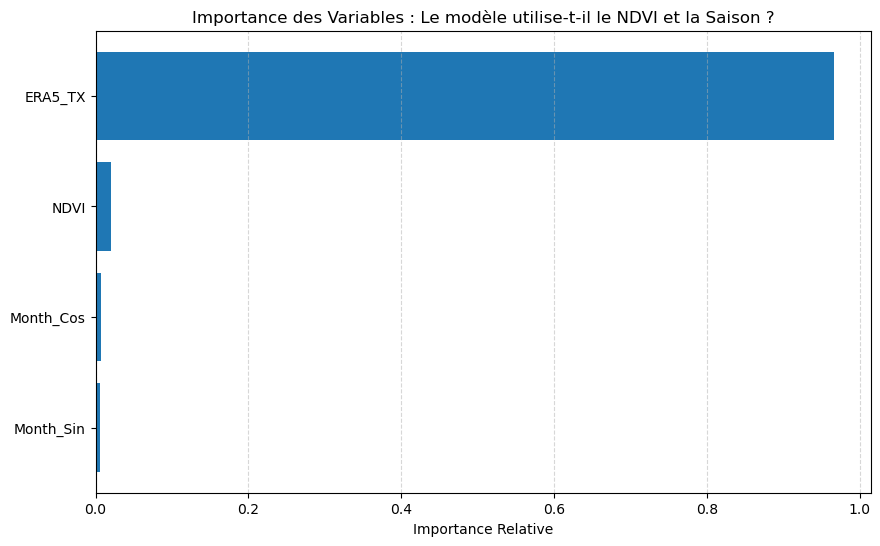

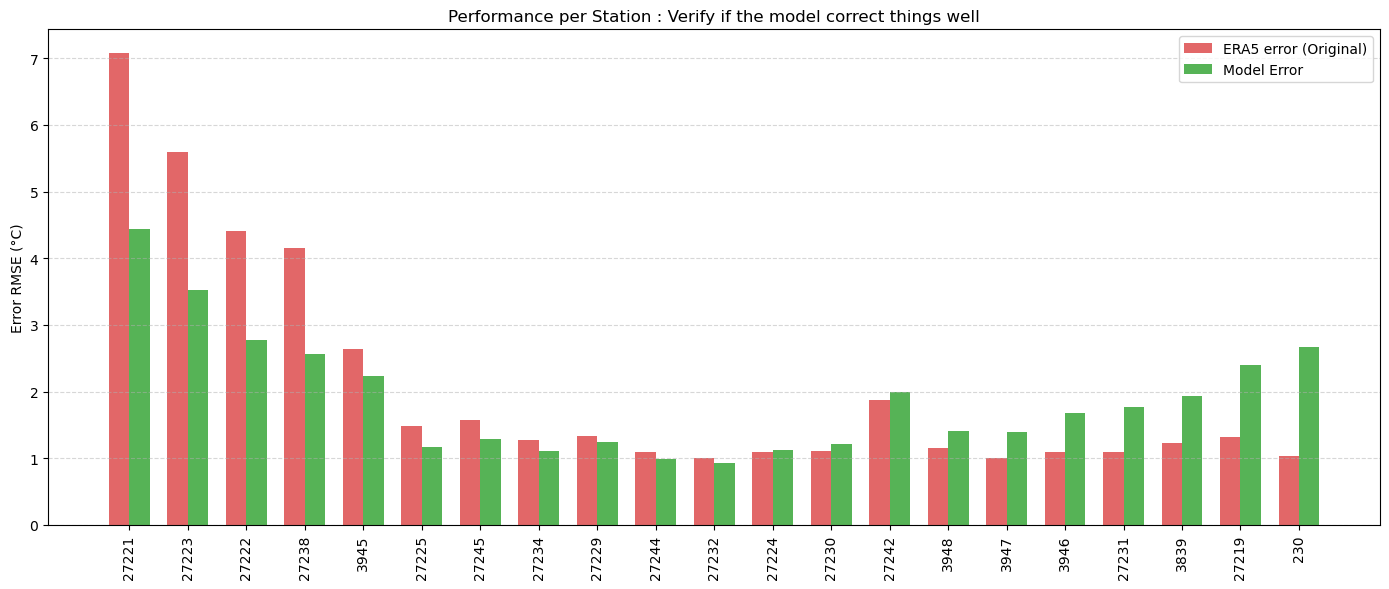

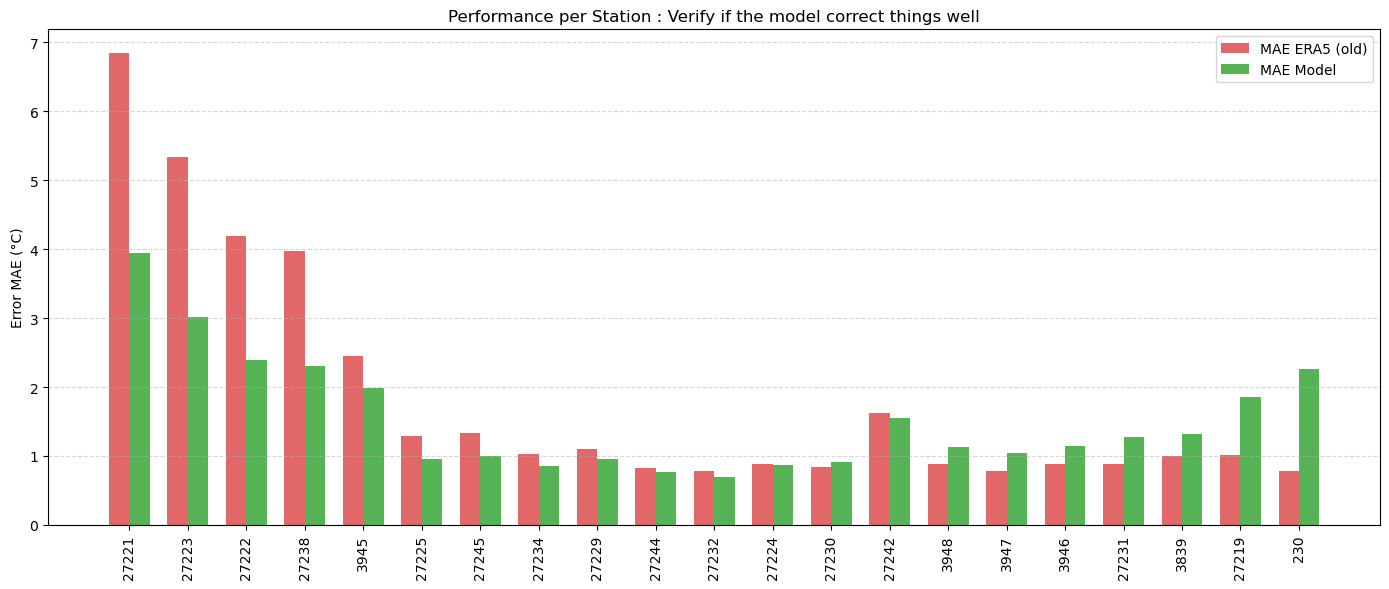

1.5360193422488202


In [59]:
importances = rf_global.feature_importances_
feature_names = ['ERA5_TX', 'NDVI', 'Month_Sin', 'Month_Cos']
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title('Importance des Variables : Le modèle utilise-t-il le NDVI et la Saison ?')
plt.barh(range(len(indices)), importances[indices], color='#1f77b4', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Importance Relative')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

results_cv_season = []
features_season = ['ERA5_TX', 'NDVI', 'Month_Sin', 'Month_Cos']
stations_list = df_model['Station_ID'].unique()

"""Predicting on each stations"""
for test_station in stations_list:
    train_data = df_model[df_model['Station_ID'] != test_station]
    test_data = df_model[df_model['Station_ID'] == test_station]
    
    if len(test_data) == 0: continue

    model_cv = RandomForestRegressor(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42)
    model_cv.fit(train_data[features_season], train_data['Station_TX'])
    
    # Prédiction
    pred_cv = model_cv.predict(test_data[features_season])
    
    # Scores
    rmse_era5 = np.sqrt(mean_squared_error(test_data['Station_TX'], test_data['ERA5_TX']))
    rmse_model = np.sqrt(mean_squared_error(test_data['Station_TX'], pred_cv))
    mae_era = np.mean(abs((test_data['Station_TX']- test_data['ERA5_TX'])))
    mae = np.mean(abs((test_data['Station_TX']- pred_cv)))
    
    results_cv_season.append({
        'Station': test_station,
        'RMSE_ERA5': rmse_era5,
        'RMSE_Corrected': rmse_model,
        'Gain': rmse_era5 - rmse_model,
        'MAE ERA5 (old)': mae_era,
        'New MAE' : mae
    })

df_res_season = pd.DataFrame(results_cv_season).sort_values('Gain', ascending=False)

# Tracé du graphique
plt.figure(figsize=(14, 6))
x = np.arange(len(df_res_season))
width = 0.35

plt.bar(x - width/2, df_res_season['RMSE_ERA5'], width, label='ERA5 error (Original)', color='#d62728', alpha=0.7)
plt.bar(x + width/2, df_res_season['RMSE_Corrected'], width, label='Model Error', color='#2ca02c', alpha=0.8)

plt.xticks(x, df_res_season['Station'], rotation=90)
plt.ylabel('Error RMSE (°C)')
plt.title('Performance per Station : Verify if the model correct things well')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
x = np.arange(len(df_res_season))
width = 0.35

plt.bar(x - width/2, df_res_season['MAE ERA5 (old)'], width, label='MAE ERA5 (old)', color='#d62728', alpha=0.7)
plt.bar(x + width/2, df_res_season['New MAE'], width, label='MAE Model', color='#2ca02c', alpha=0.8)

plt.xticks(x, df_res_season['Station'], rotation=90)
plt.ylabel('Error MAE (°C)')
plt.title('Performance per Station : Verify if the model correct things well')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
m=df_res_season['New MAE'].mean()
print(m)

## Third method : Neural Network

In [60]:
# Setuping the datas
features = ['ERA5_TX', 'NDVI', 'Month_Sin', 'Month_Cos']
target = 'Station_TX'

# Nettoyage
df_nn = df_final.dropna().copy()

X = df_nn[features].values
y = df_nn[target].values

print(df_nn['ERA5_TX'])

506     12.287079
507     11.518280
508     15.338837
509     17.218597
510     15.493073
          ...    
1204    31.530304
1205    34.282593
1206    31.609039
1207    30.368134
1208    31.131897
Name: ERA5_TX, Length: 14763, dtype: float32


In [61]:
features = ['ERA5_TX', 'NDVI', 'Month_Sin', 'Month_Cos']
target = 'Station_TX'

# Nettoyage
df_nn = df_final.dropna().copy()

X = df_nn[features].values
y = df_nn[target].values

In [62]:
from tqdm import tqdm
import os

spain_gdf = gadm_gdf[(gadm_gdf.GID_0 == "ESP")& (gadm_gdf.NAME_2 != "Madrid")].dissolve()

stations_df = pd.read_csv(stations_filepath, skiprows=17, skipinitialspace=True)
stations_df['LAT_decimal'] = stations_df['LAT'].apply(dms_to_decimal)
stations_df['LON_decimal'] = stations_df['LON'].apply(dms_to_decimal)

stations_gdf = gpd.GeoDataFrame(
    stations_df,
    geometry=gpd.points_from_xy(stations_df['LON_decimal'], stations_df['LAT_decimal']),
    crs="EPSG:4326"
)

stations_in_spain = stations_gdf[stations_gdf.within(spain_gdf.geometry.iloc[0])]
print(f"Stations trouvées en Espagne : {len(stations_in_spain)}")

X_list = []
y_list = []

start_date = pd.Timestamp("2020-01-01")
end_date = pd.Timestamp("2023-12-31")

for idx, station in tqdm(stations_in_spain.iterrows(), total=len(stations_in_spain)):
    try:
        staid = station['STAID']
        fpath = eca_tx_datafolder + f"TX_STAID{staid:06d}.txt"
        
        if not os.path.exists(fpath): continue
            
        df_s = pd.read_csv(fpath, skiprows=20, skipinitialspace=True)
        df_s = df_s[df_s['Q_TX'] == 0]
        df_s['DATE'] = pd.to_datetime(df_s['DATE'], format='%Y%m%d')
        df_s = df_s.set_index('DATE').sort_index()
        
        mask_date = (df_s.index >= start_date) & (df_s.index <= end_date)
        df_s = df_s.loc[mask_date]
        
        if len(df_s) < 50: continue 
        
        station_series = df_s['TX'] / 10.0 
        station_series.name = 'Station_TX'
        lat_s, lon_s = station.geometry.y, station.geometry.x
        
        era5_point = ds[datavar].sel(latitude=lat_s, longitude=lon_s, method="nearest")
        era5_series = era5_point.to_series() - 273.15 # Kelvin -> Celsius
        era5_series.name = 'ERA5_TX'
        
        merged = pd.concat([station_series, era5_series], axis=1).dropna()
        
        if len(merged) == 0: continue

        X_list.append(merged[['ERA5_TX']].values)
        y_list.append(merged[['Station_TX']].values)
        
    except Exception as e:
        continue
if len(X_list) > 0:
    X_all = np.vstack(X_list)
    y_all = np.vstack(y_list)
    print(f"\nDataset prêt : {X_all.shape[0]} points de données (jours * stations).")
else:
    print("Erreur : Aucun dataset n'a pu être créé. Vérifiez vos chemins et dates.")

if len(X_list) > 0:
    X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        BatchNormalization(), 
        Dropout(0.1),         
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dense(32, activation='relu'),
        Dense(1)              
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

    print("Démarrage de l'entraînement...")
    history = model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=4096, 
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )


    

Stations trouvées en Espagne : 900


100%|██████████| 900/900 [03:34<00:00,  4.19it/s]



Dataset prêt : 1143198 points de données (jours * stations).


Démarrage de l'entraînement...
Epoch 1/100


179/179 [==============================] - 6s 17ms/step - loss: 123.7445 - mae: 8.1944 - val_loss: 189.8238 - val_mae: 12.7522 - lr: 0.0010
Epoch 2/100
179/179 [==============================] - 3s 14ms/step - loss: 7.0451 - mae: 1.9917 - val_loss: 68.9503 - val_mae: 7.3967 - lr: 0.0010
Epoch 3/100
179/179 [==============================] - 3s 14ms/step - loss: 6.6061 - mae: 1.9145 - val_loss: 13.2368 - val_mae: 2.9879 - lr: 0.0010
Epoch 4/100
179/179 [==============================] - 3s 14ms/step - loss: 6.3494 - mae: 1.8661 - val_loss: 6.0100 - val_mae: 1.8066 - lr: 0.0010
Epoch 5/100
179/179 [==============================] - 3s 14ms/step - loss: 6.1834 - mae: 1.8336 - val_loss: 5.7402 - val_mae: 1.7450 - lr: 0.0010
Epoch 6/100
179/179 [==============================] - 3s 14ms/step - loss: 6.0754 - mae: 1.8125 - val_loss: 5.6651 - val_mae: 1.7283 - lr: 0.0010
Epoch 7/100
17

In [63]:
# Evaluation
y_pred=model.predict(X_test_scaled)
bias = np.mean(y_test-y_pred)
mae = np.mean(abs(y_test-y_pred))
rmse = np.sqrt(np.mean((y_test-y_pred)**2))
print(f"\n Bias: {bias:.4f} °C")
print(f"\n RMSE: {rmse:.4f} °C")
print(f"\n MAE: {mae} ")

7145/7145 [==============================] - 10s 1ms/step

 Bias: 0.0023 °C

 RMSE: 2.3895 °C

 MAE: 1.7358810530650637 


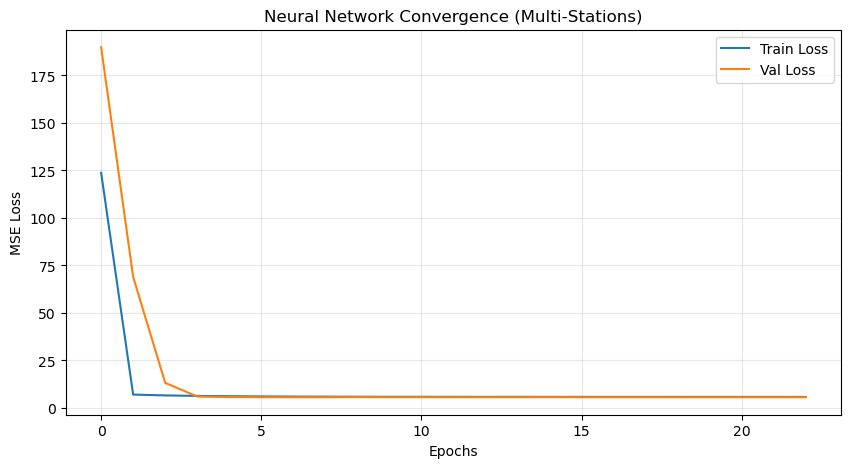

4/4 [==============================] - 0s 2ms/step


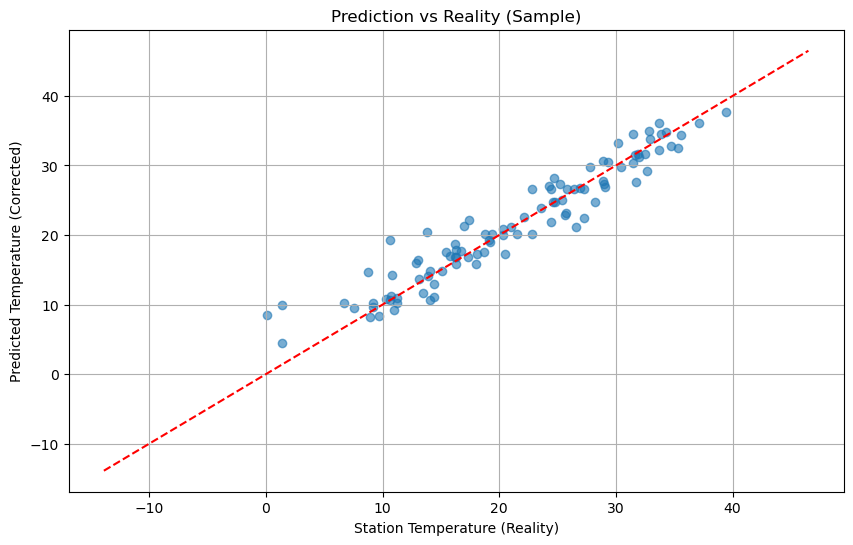

In [64]:
# Visualisation de la Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Neural Network Convergence (Multi-Stations)")
plt.ylabel("MSE Loss")
plt.xlabel("Epochs")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Visualisation Prédiction vs Réalité (sur un sous-échantillon pour lisibilité)
plt.figure(figsize=(10, 6))
subset_n = 100
plt.scatter(y_test[:subset_n], model.predict(X_test_scaled[:subset_n]), alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--') # Ligne parfaite
plt.xlabel("Station Temperature (Reality)")
plt.ylabel("Predicted Temperature (Corrected)")
plt.title("Prediction vs Reality (Sample)")
plt.grid()
plt.show()

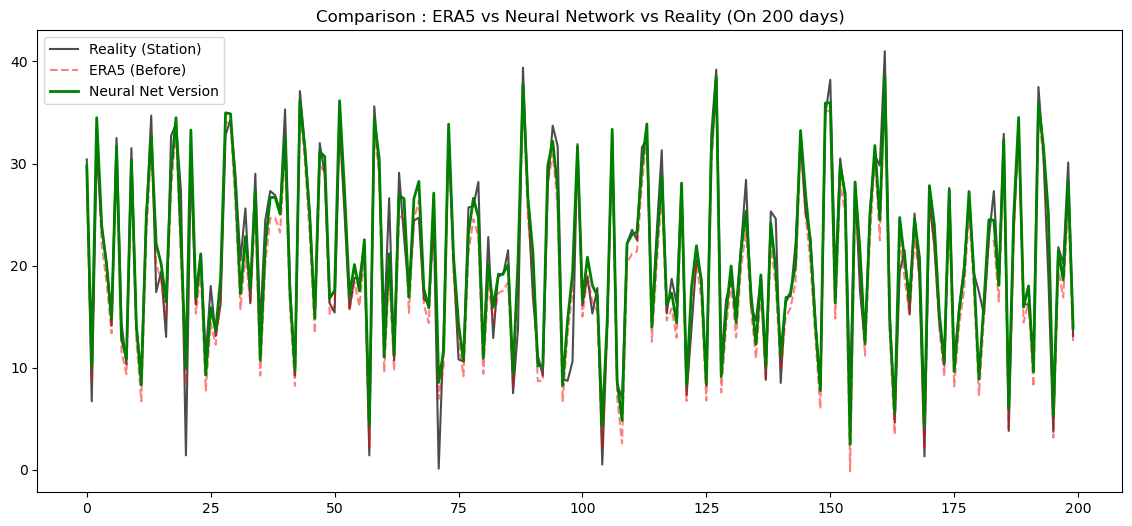

In [72]:
plt.figure(figsize=(14, 6))
num_days = 200
plt.plot(pd.Series(y_test[:num_days].flatten()), label='Reality (Station)', color='black', alpha=0.7)
plt.plot(pd.Series(X_test[:num_days, 0].flatten()), label='ERA5 (Before)', color='red', linestyle='--', alpha=0.5)
plt.plot(pd.Series(y_pred[:num_days].flatten()), label='Neural Net Version', color='green', linewidth=2)
plt.title(f'Comparison : ERA5 vs Neural Network vs Reality (On {num_days} days)')
plt.legend()
plt.show()

## Fourth method : SAX

In [74]:
main_data_folder = "data/"
gadm_filepath = main_data_folder + "gadm_410_europe.gpkg"
eca_tx_datafolder = main_data_folder + "ECA_blend_tx/"
stations_filepath = eca_tx_datafolder + "stations.txt"
era5_data_folder = main_data_folder + "derived-era5-land-daily-statistics/"

# SAX parameters
SAX_WINDOW = 7     
SAX_ALPHABET = 3   

def dms_to_decimal(dms_str):
    """Convertit les coordonnées DMS en décimal."""
    dms_str = dms_str.strip()
    sign = 1 if dms_str[0] == '+' else -1
    dms_str = dms_str[1:]
    parts = dms_str.split(':')
    return sign * (float(parts[0]) + float(parts[1])/60 + float(parts[2])/3600)

def compute_sax_encoding(series, window_size=7, alphabet_size=3):
    """
    Calcule un code entier unique représentant la forme (SAX) de la fenêtre glissante.
    """
    breakpoints = stats.norm.ppf(np.linspace(0, 1, alphabet_size + 1)[1:-1])
    
    sax_codes = []
    series_values = series.values
    
    for i in range(len(series_values)):
        if i < window_size:
            sax_codes.append(0)
            continue
            
        window = series_values[i-window_size:i]
        
        if np.std(window) < 1e-6:
            norm_window = np.zeros_like(window)
        else:
            norm_window = (window - np.mean(window)) / np.std(window)
            
        word_len = 3
        segment_size = window_size // word_len
        if segment_size < 1: segment_size = 1
        
        paa = []
        for j in range(word_len):
            start = j * segment_size
            end = (j + 1) * segment_size if j < word_len - 1 else len(window)
            paa.append(np.mean(norm_window[start:end]))
            
        code = 0
        for val in paa:
            symbol = np.sum(val > breakpoints)
            code = code * alphabet_size + symbol
            
        sax_codes.append(code)
        
    return np.array(sax_codes)

filepaths = [os.path.join(era5_data_folder, f) for f in os.listdir(era5_data_folder) if f.endswith('.nc') and '2m_temperature' in f]
ds = xr.open_mfdataset(filepaths, combine="by_coords")

gadm_gdf = gpd.read_file(gadm_filepath)
spain_gdf = gadm_gdf[(gadm_gdf.GID_0 == "ESP")&  (gadm_gdf.NAME_2 != "Madrid")].dissolve()

stations_df = pd.read_csv(stations_filepath, skiprows=17, skipinitialspace=True)
stations_df['LAT_decimal'] = stations_df['LAT'].apply(dms_to_decimal)
stations_df['LON_decimal'] = stations_df['LON'].apply(dms_to_decimal)
stations_gdf = gpd.GeoDataFrame(stations_df, geometry=gpd.points_from_xy(stations_df['LON_decimal'], stations_df['LAT_decimal']), crs="EPSG:4326")

stations_in_spain = stations_gdf[stations_gdf.within(spain_gdf.geometry.iloc[0])]
print(f"-> {len(stations_in_spain)} stations trouvées en Espagne.")

X_temp_list = [] # Temperature ERA5 
X_sax_list = []  # Code SAX 
y_list = []      # Target Station

start_date = pd.Timestamp("2020-01-01")
end_date = pd.Timestamp("2023-12-31")

for idx, station in tqdm(stations_in_spain.iterrows(), total=len(stations_in_spain)):
    try:
        staid = station['STAID']
        fpath = eca_tx_datafolder + f"TX_STAID{staid:06d}.txt"
        if not os.path.exists(fpath): continue
            
        df_s = pd.read_csv(fpath, skiprows=20, skipinitialspace=True)
        df_s = df_s[df_s['Q_TX'] == 0] # Qualité valide uniquement
        df_s['DATE'] = pd.to_datetime(df_s['DATE'], format='%Y%m%d')
        df_s = df_s.set_index('DATE').sort_index()
        df_s = df_s.loc[(df_s.index >= start_date) & (df_s.index <= end_date)]
        
        if len(df_s) < 100: continue
        
        station_series = df_s['TX'] / 10.0 # Target
        station_series.name = 'Station_TX'
        
        lat_s, lon_s = station.geometry.y, station.geometry.x
        era5_point = ds['t2m'].sel(latitude=lat_s, longitude=lon_s, method="nearest")
        era5_series = era5_point.to_series() - 273.15 # Input Temp
        era5_series.name = 'ERA5_TX'
        
        sax_values = compute_sax_encoding(era5_series, window_size=SAX_WINDOW, alphabet_size=SAX_ALPHABET)
        sax_series = pd.Series(sax_values, index=era5_series.index, name='ERA5_SAX')
        
        merged = pd.concat([station_series, era5_series, sax_series], axis=1).dropna()
        
        if len(merged) == 0: continue

        X_temp_list.append(merged[['ERA5_TX']].values)
        X_sax_list.append(merged[['ERA5_SAX']].values)
        y_list.append(merged[['Station_TX']].values)
        
    except Exception as e:
        continue

if len(X_temp_list) == 0:
    raise ValueError("No extracted datas.")

X_temp_all = np.vstack(X_temp_list)
X_sax_all = np.vstack(X_sax_list)
y_all = np.vstack(y_list)

print(f"\nDataset extracted.")



-> 900 stations trouvées en Espagne.


100%|██████████| 900/900 [09:06<00:00,  1.65it/s]


Dataset extracted.


In [75]:
indices = np.arange(len(y_all))
X_temp_train, X_temp_test, X_sax_train, X_sax_test, y_train, y_test = train_test_split(
    X_temp_all, X_sax_all, y_all, test_size=0.2, random_state=42
)

# Scaling of temperature 
scaler = StandardScaler()
X_temp_train_scaled = scaler.fit_transform(X_temp_train)
X_temp_test_scaled = scaler.transform(X_temp_test)

X_sax_train = X_sax_train.astype(int)
X_sax_test = X_sax_test.astype(int)

vocab_size = int(np.max(X_sax_all)) + 1 

input_temp = Input(shape=(1,), name='input_temp')
dense_temp = Dense(32, activation='relu')(input_temp)

input_sax = Input(shape=(1,), name='input_sax')
embed_sax = Embedding(input_dim=vocab_size, output_dim=5)(input_sax)
flat_sax = Flatten()(embed_sax)

merged = Concatenate()([dense_temp, flat_sax])

x = Dense(64, activation='relu')(merged)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)

output = Dense(1, name='output')(x)

model = Model(inputs=[input_temp, input_sax], outputs=output)

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

history = model.fit(
    x=[X_temp_train_scaled, X_sax_train], # Liste des inputs
    y=y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=2048,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_sax (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 input_temp (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 5)                 125       ['input_sax[0][0]']           
                                                                                                  
 dense_4 (Dense)             (None, 32)                   64        ['input_temp[0][0]']          
                                                                                              

7144/7144 [==============================] - 11s 2ms/step - loss: 5.7364 - mae: 1.7439

MAE on the Test Set : 1.7439 °C


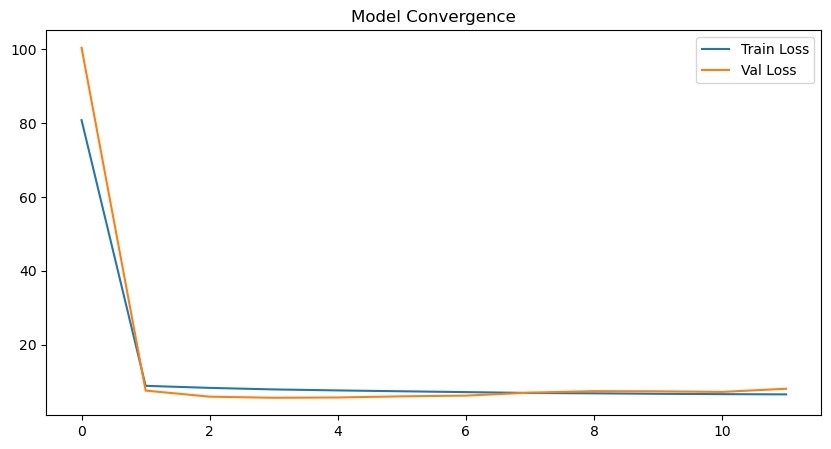

7144/7144 [==============================] - 11s 1ms/step


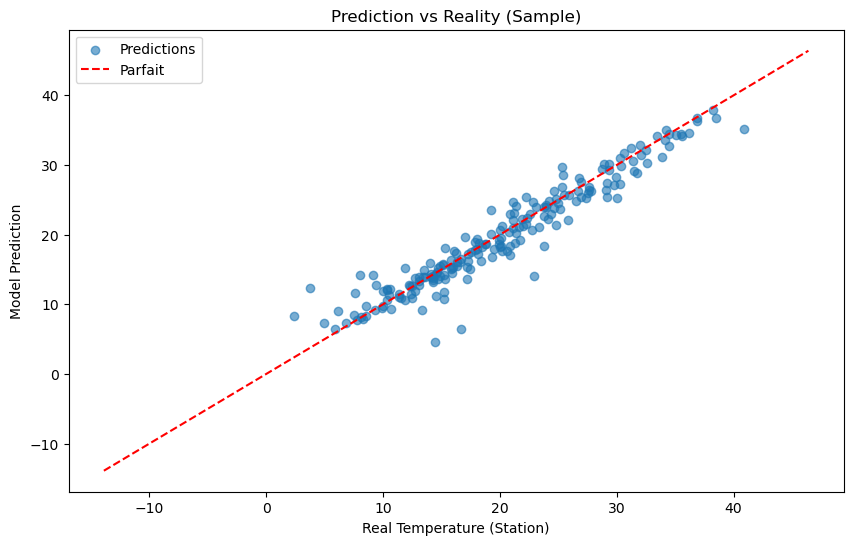

In [76]:
loss, mae = model.evaluate([X_temp_test_scaled, X_sax_test], y_test)
print(f"\nMAE on the Test Set : {mae:.4f} °C")

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Convergence")
plt.legend()
plt.show()

# Comparaison Visuelle
preds = model.predict([X_temp_test_scaled, X_sax_test])
plt.figure(figsize=(10, 6))
plt.scatter(y_test[:200], preds[:200], alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Parfait')
plt.xlabel("Real Temperature (Station)")
plt.ylabel("Model Prediction")
plt.legend()
plt.title("Prediction vs Reality (Sample)")
plt.show()

In [77]:
spain_gdf = gadm_gdf[gadm_gdf.GID_0 == "ESP"]
madrid_gdf = spain_gdf[spain_gdf.NAME_2 == "Madrid"].dissolve()

stations_in_madrid = stations_gdf[stations_gdf.within(madrid_gdf.geometry.iloc[0])]

X_test_temp_list = []
X_test_sax_list = []
y_test_list = []

start_date_test = pd.Timestamp("2020-01-01")
end_date_test = pd.Timestamp("2023-12-31")

for idx, station in tqdm(stations_in_madrid.iterrows(), total=len(stations_in_madrid)):
    try:
        staid = station['STAID']
        fpath = eca_tx_datafolder + f"TX_STAID{staid:06d}.txt"
        
        if not os.path.exists(fpath): continue
            
        df_s = pd.read_csv(fpath, skiprows=20, skipinitialspace=True)
        df_s = df_s[df_s['Q_TX'] == 0] 
        df_s['DATE'] = pd.to_datetime(df_s['DATE'], format='%Y%m%d')
        df_s = df_s.set_index('DATE').sort_index()
        df_s = df_s.loc[(df_s.index >= start_date_test) & (df_s.index <= end_date_test)]
        
        if len(df_s) < 50: continue
        
        station_series = df_s['TX'] / 10.0
        
        lat_s, lon_s = station.geometry.y, station.geometry.x
        era5_point = ds['t2m'].sel(latitude=lat_s, longitude=lon_s, method="nearest")
        era5_series = era5_point.to_series() - 273.15
        
        sax_values = compute_sax_encoding(era5_series, window_size=7, alphabet_size=3)
        sax_series = pd.Series(sax_values, index=era5_series.index)
        
        merged = pd.concat([station_series, era5_series, sax_series], axis=1).dropna()
        if len(merged) == 0: continue
        
        X_test_temp_list.append(merged.iloc[:, 1].values.reshape(-1, 1)) # ERA5
        X_test_sax_list.append(merged.iloc[:, 2].values.reshape(-1, 1))  # SAX
        y_test_list.append(merged.iloc[:, 0].values.reshape(-1, 1))      # Station
        
    except Exception as e:
        continue

if len(y_test_list) > 0:
    X_test_temp = np.vstack(X_test_temp_list)
    X_test_sax = np.vstack(X_test_sax_list).astype(int)
    y_test_madrid = np.vstack(y_test_list)
    X_test_temp_scaled = scaler.transform(X_test_temp)
    
    y_pred_madrid = model.predict([X_test_temp_scaled, X_test_sax])
    
    mae = mean_absolute_error(y_test_madrid, y_pred_madrid)
    bias = np.mean(y_test_madrid- y_pred_madrid)
    rmse = np.sqrt(mean_squared_error(y_test_madrid, y_pred_madrid))
    
    print(f"\n--- MADRID STATIONS RESULTS ---")
    print(f"MAE  : {mae:.4f} °C")
    print(f"Bias  : {bias:.4f} °C")
    print(f"RMSE : {rmse:.4f} °C")
    

else:
    print("Error on extracting data")

100%|██████████| 21/21 [00:13<00:00,  1.56it/s]

 65/923 [=>............................] - ETA: 1s

923/923 [==============================] - 1s 1ms/step

--- MADRID STATIONS RESULTS ---
MAE  : 1.4063 °C
Bias  : -0.0228 °C
RMSE : 1.8221 °C


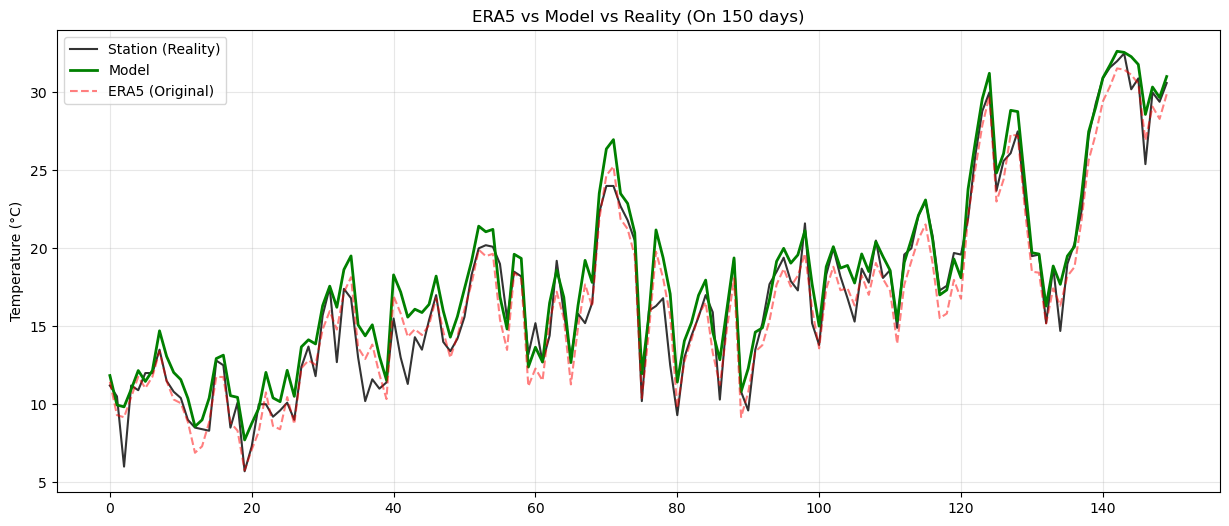

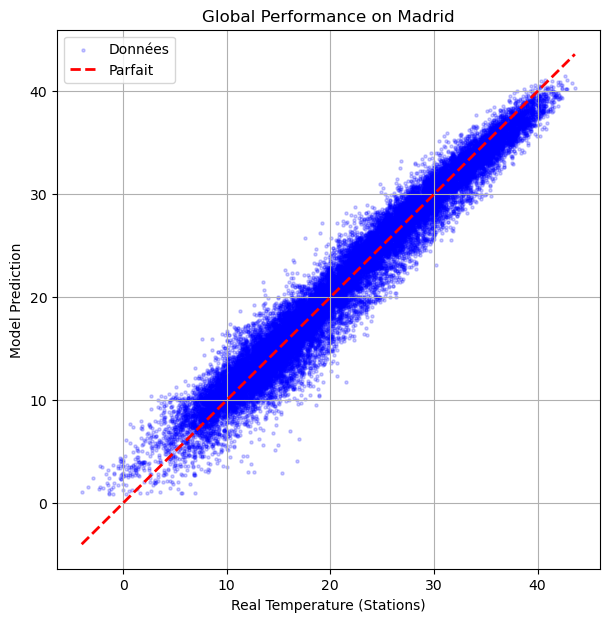

In [78]:
# Plot 1
plt.figure(figsize=(15, 6))
num_days = 150 
plt.plot(y_test_madrid[:num_days], label='Station (Reality)', color='black', alpha=0.8)
plt.plot(y_pred_madrid[:num_days], label='Model', color='green', linewidth=2)
plt.plot(X_test_temp[:num_days], label='ERA5 (Original)', color='red', linestyle='--', alpha=0.5)

plt.title(f"ERA5 vs Model vs Reality (On {num_days} days)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot 2: 
plt.figure(figsize=(7, 7))
plt.scatter(y_test_madrid, y_pred_madrid, alpha=0.2, s=5, c='blue', label='Données')
plt.plot([y_test_madrid.min(), y_test_madrid.max()], 
            [y_test_madrid.min(), y_test_madrid.max()], 'r--', linewidth=2, label='Parfait')
plt.xlabel("Real Temperature (Stations)")
plt.ylabel("Model Prediction")
plt.title("Global Performance on Madrid")
plt.legend()
plt.grid(True)
plt.show()